In [1]:
# Imports and basic setup
### UNCOMMENT THE CORRECT ONE
# If you are using Jupyter Lab
%matplotlib inline

# If you are using Jupyter Notebook
# %matplotlib notebook

import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 40})
import pandas as pd
import numpy as np
import scipy
import scipy.signal

# Comparing PVC and healthy peaks

Last exercise we calculated a wide set of features on a sample ECG recording.
In this exercise, we want to use these features to build a classifier that can separate healthy from PVC (premature ventricular contraction) heart beats.

## Ex 12.1: Data Cleaning
We are going to use the [MIT ECG database](https://physionet.org/content/mitdb/1.0.0/), which was mentioned multiple times in the lecture, for this analysis.
You can find a formatted and structured version of the DB in the `data` folder.
The files have the following structure:

- {patient_id}.csv -> The ECG recording
- {patient_id}_all.csv -> The position of the R-peaks of all heart beats (PVC or normal). All heart beats that show a different condition than PVC are already excluded
- {patient_id}_pvc.csv -> The position of all PVC heart beats in the recording.

Not all patients in the database have PVC heart beats in the recordings.

a) Find all patients that have PVC heart beats **and** normal beats

b) Create a label vector for each patient. This should consist of a 2 column dataframe. The first column should be the position of the R-peak and the second should either be `"PVC"` or `"N"`, indicating a healthy or pathological beat.

c) Count how many PVC vs. normal heart beats exist for these filtered patients

d) Based on your findings, describe potential issues a classification using this data could have.

### Solution:

c) The two classes (PVC vs. normal) are unbalanced by almost 10x.
If we do not account for this, classifiers often tend to be biased towards the majority class.
However, we will see later that our classifier appears not to be impacted by this.

In [2]:
from pathlib import Path

data = Path('./data')
patients_with_pvc = []

### BEGIN SOLUTION
for patient in data.glob('*_pvc.csv'):
    pvcs = pd.read_csv(patient)
    all_beats = pd.read_csv(str(patient).rsplit('_', 1)[0] + '_all.csv')
    if len(pvcs) > 0 and len(all_beats) > len(pvcs):
        patients_with_pvc.append(patient.stem.split('_')[0])
### END SOLUTION
patients_with_pvc = sorted(patients_with_pvc)
print(patients_with_pvc)

['100', '102', '104', '105', '106', '108', '114', '116', '119', '121', '123', '200', '201', '202', '203', '205', '208', '209', '210', '213', '215', '217', '219', '221', '223', '228', '230', '231', '233', '234']


In [3]:
# Create label vectors
### BEGIN SOLUTION
all_beat_labels = dict()

for patient in patients_with_pvc:
    pvc_beats = pd.read_csv('./data/{}_pvc.csv'.format(patient), header=0, index_col=0)
    all_beats = pd.read_csv('./data/{}_all.csv'.format(patient), header=0, index_col=0)
    # Set all labels to N for now
    all_beats['label'] = 'N'
    # Overwrite the correct cols for the PVC label
    all_beats.loc[all_beats['R'].isin(pvc_beats['PVC']), 'label'] = 'PVC'
    
    all_beat_labels[patient] = all_beats.set_index('R')
    
all_beat_labels = pd.concat(all_beat_labels, names=['patient_id']).reset_index()
all_beat_labels.head(5)
### END SOLUTION

,patient_id,R,label
0,100,77,N
1,100,370,N
2,100,662,N
3,100,946,N
4,100,1231,N


In [4]:
# Count PVC vs non PVC
### BEGIN SOLUTION
all_beat_labels.groupby('label').size()
### END SOLUTION

label
N      55882
PVC     6608
dtype: int64

## Ex. 12.2: Calculating features

As we learned in the lecture, we need to reduce the dimensionality of our data by calculating features for each heartbeat.

a) Using the code from last exercise, extract all heartbeats from the selected patients. Apply the same band-pass filter to each recording we used last exercise.

b) Calculate all features from last exercise for all heart beats. Use the first **healthy** heart beat of each patient for the template feature.

c) Calculate a set of “generic” features for each heart beat: *mean*, *std*, *minimum*, *maximum*

c) Compose all features into one matrix, where each row belongs to one heartbeat. Create a single matrix/`pd.DataFrame` combining all patients. Add a column indicating the label (`N` or `PVC`).

In [5]:
# Helper funcs from last exercise
def extract_qrst_complexes(signal, r_peaks, sampling_rate=360):
    """Extract all qrst complexes from a continous signal.
    
    Cuts out a region of -50ms to 300ms around each provided R-peak
    
    Args:
        signal: np.array of ecg signal
        r_peaks: list of indices indicating the postion of R-peaks in the signal
        sampling_rate: Ssampling rate of the recording
        
    Returns:
        qrst: np.array with fixed number of culumns and one qrst complex per row
    """
    signal = np.array(signal)
    start = r_peaks - int(50 / 1000 * sampling_rate)
    end = r_peaks + int(300 / 1000 * sampling_rate)

    qrst = []
    for s, e in zip(start, end):
        qrst.append(signal[s:e])
    qrst = np.array(qrst)
    return qrst

def find_q_peak(qrst, sampling_rate=360):
    """Find the Q peak in an array of qrst complexes extracted before.
    
    The Q peak is the first valley to the left of the R-Peak
    
    Returns:
        The relative distance from the R-Peak in samples
    """
    r_peak_pos = int(50/1000 * sampling_rate)
    index_q = np.argmin(qrst[:, :r_peak_pos], axis=-1)
    index_q = r_peak_pos - index_q
    return index_q

def find_s_peak(qrst, sampling_rate=360):
    """Find the S peak in an array of qrst complexes extracted before.
    
    The S peak is the first valley to the right of the R-Peak
    
    Returns:
        The relative distance from the R-Peak in samples
    """
    r_peak_pos = int(50/1000 * sampling_rate)
    # Search 80ms to the right of the r_peak
    search_index = int(80/1000 * sampling_rate)
    
    index_s = np.argmin(qrst[:, r_peak_pos: r_peak_pos + search_index], axis=-1)
    index_s = index_s
    return index_s

In [6]:
def calc_all_features_for_patient(signal, peaks, labels):
    """Extract all heartbeats and calc all features for a patient.
    
    Args:
        signal: np.array of ecg signal
        peaks: pd.DataFrame with a column called "R" containing the position of all R-peaks
        labels: array with either "N" or "PVC" for each r-peak
        
    Returns:
        DataFrame with 1 column per feature and 1 column for the label
    """
    peaks = peaks.copy()
    # Remove peaks that are too close to the beginning or end of the dataset
    peaks = peaks[peaks['R'].between(20, len(signal) - 110)]
    
    # Extract the individual complexeses and important events withing the complex
    ### BEGIN SOLUTION
    qrst_complexes = extract_qrst_complexes(signal, peaks['R'], sampling_rate=360)
    peaks['Q'] = peaks['R'] - find_q_peak(qrst_complexes)
    peaks['S'] = peaks['R'] + find_s_peak(qrst_complexes)
    ### END SOLUTION
    
    features = pd.DataFrame()

    # Calculate all features from last week
    ### BEGIN SOLUTION
    # QRS Width
    features['QRS_Width'] = (peaks['S'] - peaks['Q']) / sampling_rate

    # QR Amplitude difference
    # Calculate the amplitude difference between the R-peak and the Q-valey
    features['QR_amplitude'] = signal.values[peaks['R'].values] - signal.values[peaks['Q'].values]

    # RS Amplitude difference
    # Calculate the amplitude difference between the R-peak and the S-valey
    features['RS_amplitude'] = signal.values[peaks['R'].values] - signal.values[peaks['S'].values]

    # QRST Area
    # Calculate the area under each QRST complex after substracting the mean value of each complex to
    # normalize the baseline
    features['QRST_area'] = np.sum(np.abs((qrst_complexes.T - np.mean(qrst_complexes, axis=-1)).T), axis=-1)

    # Template Match
    # Find the first "normal QRS" complex
    first_normal = list(labels).index('N')  # index return the first occurence
    
    # We assume the first peak in the series is a normal QRST complex
    # Substract the baseline (minimum) from every qrst complex and then calculate the normalised dot-product (a*b/(|a||b|))
    baseline_correctes_qrst = (qrst_complexes.T - np.min(qrst_complexes, axis=-1)).T
    baseline_correctes_norm = np.linalg.norm(baseline_correctes_qrst, axis=-1)
    distance = np.dot(baseline_correctes_qrst, baseline_correctes_qrst[first_normal])
    distance /= baseline_correctes_norm * baseline_correctes_norm[first_normal]
    features['Template'] = distance
    ### END SOLUTION
    
    # Calculate a set of generic features
    ### BEGIN SOLUTION
    features['Mean'] = np.mean(qrst_complexes, axis=1)
    features['Std'] = np.std(qrst_complexes, axis=1)
    features['Min'] = np.min(qrst_complexes, axis=1)
    features['Max'] = np.max(qrst_complexes, axis=1)
    ### END SOLUTION
    
    # Add the label column
    ### BEGIN SOLUTION
    features['label'] = labels
    ### END SOLUTION
    return features


In [7]:
sampling_rate = 360  # hz

feature_all_patients = []
### BEGIN SOLUTION
for patient in patients_with_pvc:
    signal = pd.read_csv('./data/{}.csv'.format(patient), index_col=0)['ecg']

    # Optionally apply a bandpass filter to the signal (3-50 Hz passband)
    # Test all computations in this exercise  with and without the filter
    bandpass_filter = scipy.signal.butter(5, (3, 50), btype='bandpass', fs=sampling_rate)
    signal = pd.Series(scipy.signal.filtfilt(*bandpass_filter, signal))
    # Calculate all features
    beats = all_beat_labels[all_beat_labels['patient_id'] == str(patient)]
    feature_all_patients.append(calc_all_features_for_patient(signal, beats[['R']], beats['label']))
### END SOLUTION
feature_all_patients = pd.concat(feature_all_patients)
feature_all_patients.head(5)

,QRS_Width,QR_amplitude,RS_amplitude,QRST_area,Template,Mean,Std,Min,Max,label
0,0.047222,1.304419,1.272772,12.740724,1.000000,0.007252,0.211623,-0.254819,1.049600,N
1,0.052778,1.473421,1.399725,16.753887,0.991165,0.009106,0.254250,-0.311316,1.162106,N
2,0.044444,1.461040,1.428218,13.951622,0.984203,0.005351,0.238643,-0.292782,1.195919,N
3,0.047222,1.442177,1.351256,13.375388,0.983333,0.004366,0.233247,-0.326319,1.147351,N
4,0.044444,1.344296,1.313935,12.736080,0.996275,0.004360,0.212286,-0.265043,1.079253,N


## Ex. 12.3: Feature Selection

Now that we calculated a set of features it is important to check if they provide the separation we hoped.
This is an important step, as our classifier can never be better than its data/features.
If the features cannot separate our classes of interest, our classifier cannot magically achieve this.

A typical way to do this, is to plot the histogram for each feature.

a) Look at the visualisation below. Describe what you would expect from a “good” feature.

b) Pick 4 features, you would consider good and store their names in an array for later use

c) Explain the limitations of selecting features just based on a 1D histogram

### Solution:

a) A good feature should have a minimal overlap between the histograms of the two classes

b) No feature is perfect, but we can see differences in the histograms in all features. A potential set of “good” features would be `[‘QRS_Width’, ‘Template’, ‘Mean’, ‘RS_amplitude’]`

c) Combining multiple features can often reveal decision boundaries that are not visible in lower dimensions. Think about datasets that can be separated only by a diagonal in the 2D space.

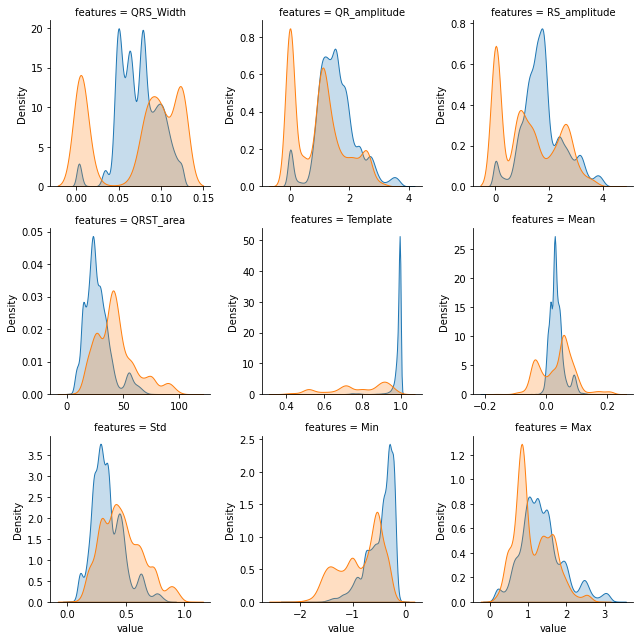

In [8]:
import seaborn as sns
plot_longform_df = feature_all_patients.melt(['label'], value_name='value', var_name='features')
g = sns.FacetGrid(plot_longform_df, col='features', hue="label", sharex=False, sharey=False, col_wrap=3)
g = (g.map(sns.kdeplot, 'value', fill=True))

In [9]:
### BEGIN SOLUTION
selected_features = ['QRS_Width', 'Template', 'Mean', 'RS_amplitude']
### END SOLUTION

## Ex. 12.4: Training a classifier

With our set of features, we will now train a classifier.
This is usually a crucial step, as the choice of classifier and and its parameters will heavily influence the final performance.
While there are some rules of thumb, most of time this requires some trial and error or a proper grid search.

For this exercise we are going to use a *RandomForestClassifier* (and leave all parameters at default), because it is simple to use and requires no further pre-processing of our features.
Have a look at the [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) for further information.

To test the performance of a classifier, we need to decide on a “Test Set”.
A part of our data, we will not use to train the classifier, but only to evaluate its final performance.
This is called a train-test-split and sklearn has some [helper functions](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) for this.

a) Use the documentation provided above to assemble a simple pipeline consisting of a train-test-split with 30% test data and stratification. Then train a Random Forest using this train data.

b) Explain why “stratification” could be important for the given problem.

c) Name potential other issues of using a single train-test split like shown here.

d) Calculate the confusion matrix and the accuracy for this classification. Explain the meaning of each entry in the confusion matrix.

e) Repeat the classification with all features (instead of just your selected features). Use the same train-test-split. Compare the results.

### Solution:

b) Stratification ensures that the percentage of normal vs. PVC heart-beat is identical in the train and the test data. If we just pick random samples it might happen, that only a few abnormal heart beats and up in one of the two groups. The higher the class imbalance the larger the chance for this happening. Note that stratification is not equivalent to “class balancing”, which should be considered in case of large class imbalances. A great paper on this topic is called “Learning from unbalanced data”.

c) A single train-test split can cause an “unfavorable” split. A better solution is to use multiple train-test splits, for example by using cross-validation. Further, we performed the train-test split on the level of heart beats. However, individual heart-beats from the same patient are expected to be very similar. This means that if some heart-beats of the same patients end up in the test set and some end up in the train test, we basically have the “same” data point in both sets. This could be considered a “train-test-leak”. A solution would be to perform the train-test-split on the level of subjects.

d) Accuracy tells you how many samples are correctly classified. However, in case of unbalanced classes that might not tell you the full picture. The confusion matrix provides you with further information:
The *True Positive* (TP) rate, the *False Negative* (FN), the *True Negative* (TN), and the *False Positive* (FP). Because we want to detect abnormal beats, PVC is our *positive* (i.e. TP is the rate of PVCs we detected correctly)

In [10]:
# Select your features from the datadrame and create a feature and a label vector
### BEGIN SOLUTION
data = feature_all_patients[selected_features]
labels = feature_all_patients['label']
### END SOLUTION

In [11]:
# Split data into training and test data
### BEGIN SOLUTION
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data.values, labels.values, test_size=0.3, stratify=labels.values, random_state=12)
### END SOLUTION

In [12]:
# Create a Random Forrest classifier. You can leave all parameters as default.
### BEGIN SOLUTION
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators=100)
### END SOLUTION

# Train the classifier using the training data
### BEGIN SOLUTION
classifier = classifier.fit(X_train, y_train)
### END SOLUTION

[[16694    69]
 [  129  1853]]
0.9894371832488663


/Users/falk/Documents/FAU/programming/environments/biosig_exercise/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


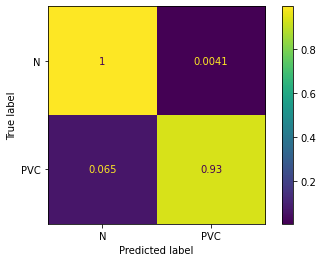

In [13]:
from sklearn.metrics import confusion_matrix, accuracy_score, plot_confusion_matrix

# Calculate the confusion matrix and the accuracy
### BEGIN SOLUTION
predicted = classifier.predict(X_test)
print(confusion_matrix(y_test, predicted, labels=['N', 'PVC'], normalize=None))
print(accuracy_score(y_test, predicted))

plot_confusion_matrix(classifier, X_test, y_test, normalize='true');
### END SOLUTION

[[16728    35]
 [   84  1898]]
0.99365164043745


/Users/falk/Documents/FAU/programming/environments/biosig_exercise/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


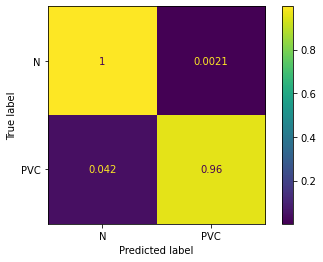

In [14]:
# Repeat the classification with all features
### BEGIN SOLUTION
data = feature_all_patients.drop(['label'], axis=1)
labels = feature_all_patients['label']
X_train, X_test, y_train, y_test = train_test_split(data.values, labels.values, test_size=0.3, stratify=labels.values, random_state=12)
classifier = RandomForestClassifier(n_estimators=100)
classifier = classifier.fit(X_train, y_train)

predicted = classifier.predict(X_test)
print(confusion_matrix(y_test, predicted, labels=['N', 'PVC'], normalize=None))
print(accuracy_score(y_test, predicted))

plot_confusion_matrix(classifier, X_test, y_test, normalize='true');
### END SOLUTION

## Ex. 12.5: Discussing classifier performance

a) Would you trust the classifier to make an automatic decision in a clinical environment?

b) For which performance parameter would you try to optimize the classifier performance? (TP-rate or TN-rate?)

c) What other issues do you see with the current system?

### Solution:

a) Can be debated, but I would say no. The performance is good, but we looked at an artificial case where only one heart condition exists. We have no idea how our classifier would react to anything abnormal.

b) This depends on your final deployment. On the one hand, you want to find all abnormal heartbeats (high TP). However, it is likely that this will also increase the FP rate. This means healthy subjects are considered ill. Depending on the consequences this might not be desirable either. For example, in a closed loop system (fully automated) a FP might end in a wrong treatment for the patient. Therefore, given that perfect classification is seldom possible you need to find a compromise for your specific application.